# Курс "Практикум по математической статистике"
# 3 курс ФПМИ МФТИ, осень 2020
## Домашнее задание 2. Методы нахождения оценок
### Дедлайн --- 26 октября 9:00

Это первое обязательное домашнее задание нашего курса. Мы предлагаем выполнять задания прямо в этом ноутбуке. Пожалуйста, не стирайте условия задач.

Информация о выполнении и курсе в целом есть в <a href=https://docs.google.com/document/d/1kd85QRAS8fbxRxpMzP2IsbQ_YcVsU-Aczqd6ErXgIDg/edit#>этой папке</a>.

В этом и последующих заданиях вам потребуется выполнять генерацию случайных величин из некоторого распределения. Для этого вам понадобится библиотека scipy.stats. Мы настоятельно рекомендуем для генерации выборок использовать именно эту библиотеку.

Настоятельно рекомендуемая форма оформления домашних заданий — это Jupyter Notebook и его pdf-версия с:

* условием задачи,
* решением (если требуется некоторый теоретический вывод),
* описанием плана решения, который потом реализуется в коде, 
* собственно кодом, 
* построенными графиками (если это требуется) и **выводом**, который как правило должен заключаться в объяснении практических результатов с использованием теоретических фактов. ***Вывод требуется даже в том случае, если в условии об этом явно не сказано!***
* некоторыми другими вещами, если об этом будет указано в задании.

Оценка за каждую задачу складывается из правильного выполнения всех этих пунктов. Закрывая на них глаза, вы сознательно понижаете свою оценку.

Каждая задача оценивается в 10 баллов.

Загрузим все необходимые датасеты. Если что-то пошло не так, то просто скачайте файлы по ссылке вручную.

In [2]:
!pip install -q gdown
!gdown https://drive.google.com/uc?id=1fMQ0H-_E4U25XHB2SH7ryoZPLG2MHlLQ
!gdown https://drive.google.com/uc?id=1cJywRii7wBZa0B2uAvvu56JFCLPnlOSs

Downloading...
From: https://drive.google.com/uc?id=1fMQ0H-_E4U25XHB2SH7ryoZPLG2MHlLQ
To: /home/syrnik/stats/Cauchy.csv
100%|██████████████████████████████████████| 18.7k/18.7k [00:00<00:00, 19.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cJywRii7wBZa0B2uAvvu56JFCLPnlOSs
To: /home/syrnik/stats/Weibull.csv
100%|██████████████████████████████████████| 17.9k/17.9k [00:00<00:00, 4.19MB/s]


In [3]:
import pandas as pd
import numpy as np
from scipy import stats as sps

from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", font_scale=1.4)

## Задача 1

На высоте 1 метр от поверхности Земли закреплено устройство,
которое периодически излучает лучи на поверхность Земли (считайте,
что поверхность Земли представляет из себя прямую). Пусть $l$ —
перпендикуляр к поверхности Земли, опущенный из точки, в которой
закреплено устройство. Угол к прямой $l$ (под которым происходит
излучение) устройство выбирает случайно из равномерного
распределения на от\-резке $\left(-\frac{\pi}{2}, \frac{\pi}{2}\right)$ (все выборы
осуществляются независимо). В этих предположениях точки пересечения
с поверхностью имеют распределение Коши с плотностью $p(x) =
\frac{1}{\pi(1 + (x-x_0)^2)}.$ Неизвестный параметр сдвига $x_0$
соответствует проекции точки расположения устройства на поверхность
Земли (направление оси и начало координат на поверхности Земли
выбраны заранее некоторым образом независимо от расположения
устройства). В файле Cauchy.csv находятся координаты точек
пересечения лучей с поверхностью Земли.

In [5]:
sample_1 = pd.read_csv("Cauchy.csv")["sample"].values

 Оцените параметр сдвига
методом максимального правдоподобия 
* по первым 10 измерениям
* по первым 100 измерениям
* по всей выборке. 

Оценку произведите по сетке (т.е. возьмите набор
точек с некоторым шагом и верните ту, на которой достигается
максимум функции правдоподобия). Известно, что параметр сдвига принадлежит интервалу $[-1000, 1000].$ Выберите шаг равным 0.01. Интервал можете итеративно уменьшать, но не стоит делать его длину меньше 50.


Сделаю три разных функции правдоподобия для разного количества измерений. Чтобы посчитать каждую из них я создам двумерный массив, состоящий из элементов вида $x - x_0$. Затем я произведу операции с этим массивом, чтобы в каждой ячейке получилось значение функции плотности от данных параметра и измерения. А затем перемножу строчки матрицы, тем самым получив значения соответствующей функции правдоподобия в каждом значении параметра.

Для первой функции я буду искать максимальное значение на интервале $[-1000, 1000]$. Для второй я буду просматривать только интервал длины $400$ такой что в его середине находится оценка параметра $x_0$ из первого эксперимента. Для третьей функции интервал длины $200$ вокруг оценки параметра $x_0$ из второго эксперимента

In [6]:
# Делаем массивы измерений и возможных значений параметра
x_0 = np.arange(-1000, 1000.001, 0.01)
x = sample_1[0:10]


# Для массива параметров просто скопируем первую строчку в 10 остальных
x_0_matrix = np.tile(x_0, (len(x), 1))
# Для массива аргументов мы так же скопируем первую строчку в len(x_0) строк, но потом транспонируем массив, 
#чтобы получить правильную размерность
x_matrix = np.tile(x, (len(x_0), 1))
x_matrix = np.transpose(x_matrix)


# Работаем с двумя матрицами, чтобы получить значения плотности
dens_matrix = 1 / (np.pi*(1 + (x_matrix - x_0_matrix)**2))


# Перемножим строки матрицы друг на друга чтобы получить значения функции правдоподобия 
#от 10 измерений для каждого из параметров
likelihood_func = np.prod(dens_matrix, axis=0, dtype = np.longdouble)

Теперь найдем среди значений максимум и выделим границы параметров для функции правдоподобия от 100 измерений

In [7]:
first_max_val = np.max(likelihood_func)
first_max_indx = np.where(likelihood_func == first_max_val)
print(x_0[first_max_indx[0]])

[208.53]


Значение максимума выпало на параметр $x_0$ равный $208.53$. Значит более точное значение параметра будем искать на интервале $[8.53, 408.53]$

In [8]:
# Делаем массивы измерений и возможных значений параметра
x_0 = np.arange(8.53, 408.54, 0.01)
x = sample_1[0:100]


# Для массива параметров просто скопируем первую строчку в len(x) остальных
x_0_matrix = np.tile(x_0, (len(x), 1))
# Для массива аргументов мы так же скопируем первую строчку в len(x_0) строк, но потом транспонируем массив, 
#чтобы получить правильную размерность
x_matrix = np.tile(x, (len(x_0), 1))
x_matrix = np.transpose(x_matrix)


# Работаем с двумя матрицами, чтобы получить значения плотности
dens_matrix = 1 / (np.pi*(1 + (x_matrix - x_0_matrix)**2))


# Перемножим строки матрицы друг на друга чтобы получить значения функции правдоподобия 
#от 100 измерений для каждого из параметров
likelihood_func = np.prod(dens_matrix, axis=0, dtype = np.longdouble)

Снова найдем среди значений максимум и выделим границы параметров для функции правдоподобия от всех измерений

In [9]:
second_max_val = np.max(likelihood_func)
second_max_indx = np.where(likelihood_func == second_max_val)
print(x_0[second_max_indx[0]])

[207.9]


Значение максимума выпало на параметр $x_0$ равный $207.9$. Значит более точное значение параметра будем искать на интервале $[107.9, 307.9]$

In [10]:
# Делаем массивы измерений и возможных значений параметра
x_0 = np.arange(107.9, 307.91, 0.01)
x = sample_1


# Для массива параметров просто скопируем первую строчку в len(x) остальных
x_0_matrix = np.tile(x_0, (len(x), 1))
# Для массива аргументов мы так же скопируем первую строчку в len(x_0) строк, но потом транспонируем массив, 
#чтобы получить правильную размерность
x_matrix = np.tile(x, (len(x_0), 1))
x_matrix = np.transpose(x_matrix)


# Работаем с двумя матрицами, чтобы получить значения плотности
dens_matrix = 1 / (np.pi*(1 + (x_matrix - x_0_matrix)**2))


# Перемножим строки матрицы друг на друга чтобы получить значения функции правдоподобия 
#от всех измерений для каждого из параметров
likelihood_func = np.prod(dens_matrix, axis=0, dtype = np.longdouble)

Находим приблизительно самое точно значение параметра $x_0$

In [11]:
third_max_val = np.max(likelihood_func)
third_max_indx = np.where(likelihood_func == third_max_val)
print(x_0[third_max_indx[0]])

[207.98]


Сравните полученные результаты с `sps.cauchy.fit`

In [12]:
print(sps.cauchy.fit(sample_1)[0])

207.97772827944334


Вывод: мы очень хорошо оценили параметр, так как он отличается от оценки sps.cauchy.fit всего-лишь на 0.003

## Задача 2
В банкомате "Тинькофф" в НК МФТИ каждую минуту подсчитывается баланс по
сравнению с началом дня (6 часов утра). В полночь работники банка
измеряют две величины: $X^1$ – максимальное значение баланса за
день, $X^2$ – значение баланса в полночь. Считается, что величина
$X = X^1 - X^2$ имеет распределение Вейбулла с функцией распределения $F(x) = 1 - e^{-x^\gamma} (x > 0),$ где $\gamma > 0$ –
параметр формы. В течение 10 лет каждый день банк проводил
измерение величины $X,$ получив в результате выборку $X_1, \ldots,
X_{3652}.$ В файле Weibull.csv находятся соответствующие измерения.

In [4]:
sample_2 = np.loadtxt("Weibull.csv")

В данных есть выбросы. Конекретно числа 0 которых по определению быть не может. Нужно выкинуть эти данные и работать только с теми, которые имеют смысл

In [5]:
real_sample_2 = sample_2[sample_2 != 0]

Проведем небольшой предварительный анализ. Итак, если наши данные распределены согласно распределению Вейбулла, то справедливы следующие рассуждения:
$$
\begin{aligned} F(x) &=1-e^{-(x)^{\gamma}} \\-\ln (1-F(x)) &=x^{\gamma} \\ \underbrace{\ln (-\ln (1-F(x)))}_{y^{\prime}} &=\underbrace{\gamma \ln x}_{\text {kx }^{\prime}} \end{aligned}
$$
А значит и
$$
\underbrace{\ln (-\ln (1-\hat{F}(x)))}_{y^{\prime}} ≈\underbrace{\gamma \ln x}_{\text {kx }^{\prime}}
$$
Подсчитайте эмпирическую функцию распределения и 
$$y\prime = \ln (-\ln (1-\hat{F}(x))) \quad x' = ln x$$
 где $x$ – элементы исходной выборки. Постройте график (`plt.scatter`) выделив данные за первые четыре года красным цветом (`sample_2[:1461]`), остальные синим (`sample_2[1461:]`). Не забудьте про `alpha=0.05` и легенду. Такой график называется `Weibull plot` и является аналогом `qqplot` для распределения Вейбулла. 


Посчитаю количество нулей в выборке `sample_2[:1461]`, чтобы понять сколько 4 года будет составлять от выборки без выбросов

In [6]:
zeros = np.count_nonzero(sample_2[:1461] == 0)
print(zeros)

199


Следовательно график по 4м годам будем строить по значениям `real_sample_2[:1262]`

In [7]:
# Размер выборки
N = len(real_sample_2)

In [8]:
from statsmodels.distributions.empirical_distribution import ECDF

ecdf_for_weibull = ECDF(real_sample_2)

Использую логарифмический масштаб по $x$ потому что так красиво

<ipython-input-9-b38c30a9dd1e>:9: RuntimeWarning: divide by zero encountered in log
  plt.scatter(real_sample_2[1262:], np.log(-np.log(1 - ecdf_for_weibull(real_sample_2[1262:]))),


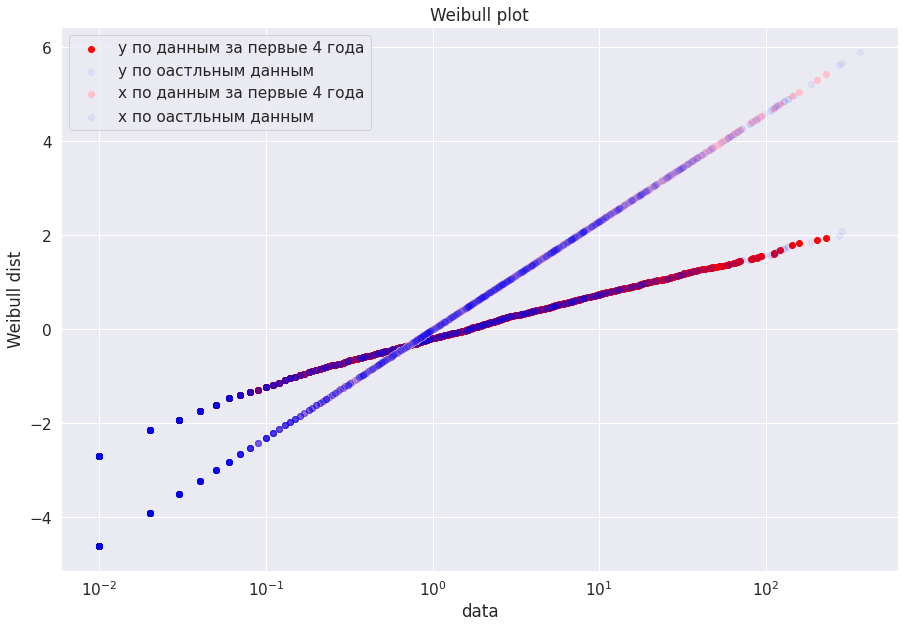

In [9]:
plt.figure(figsize=(15, 10))
plt.title('Weibull plot')
plt.xscale('log')
# Не ставлю прозрачность для красных точек, чтобы их было лучше видно на общем графике

# Значения y
plt.scatter(real_sample_2[:1262], np.log(-np.log(1 - ecdf_for_weibull(real_sample_2[:1262]))), 
                                                color = 'red',  label = 'y по данным за первые 4 года')
plt.scatter(real_sample_2[1262:], np.log(-np.log(1 - ecdf_for_weibull(real_sample_2[1262:]))), 
                                                color = 'blue', alpha=0.05, label = 'y по оастльным данным')

# Делаю цвет данных за первые 4 года розовым, чтоб было видно различие на графике
# Значения x
plt.scatter(real_sample_2[:1262], np.log(real_sample_2[:1262]), color = 'pink',  
                                                                        label = 'х по данным за первые 4 года')
plt.scatter(real_sample_2[1262:], np.log(real_sample_2[1262:]), color = 'blue', alpha=0.05, 
                                                                        label = 'х по оастльным данным')

plt.xlabel("data")
plt.legend()
plt.ylabel("Weibull dist")
plt.show()

Сделайте вывод.

**Вывод**: Параметр $\gamma$ находистся где-то между $0.1$ и $1$. Ближе к $1$

Оцените параметр формы методом максимального правдоподобия 
* по
первым 4 годам; 
* по всей выборке.
Оценку произведите по сетке (в
логарифмической шкале). Известно, что $\log_{10}\gamma \in [-2, 2].$
Выберите шаг равным $10^{-3}.$

Плотность распределения Вейбулла, где есть только параметр формы, а параметр масштаба равен 1, выражается функцией: $p(x) = \gamma x^{\gamma - 1} e^{-x^\gamma}$

In [ ]:
# Делаем массив измерений по всем годам и массив всех возможных значений параметра
gamma = np.arange(0.01, 100.001, 0.001)
x = real_sample_2[0:1262]
x_T = x[np.newaxis, :].T


# Получим значения x
x_times_gamma = x_T ** gamma
x_times_gamma_minus_1 = x_T ** (gamma - 1)

# Получим промежуточные значения
x_times_gamma_minus_1 = gamma * x_times_gamma_minus_1
exp_val = np.exp(-x_times_gamma)


# Получим последнюю матрицу, состоящую из значений функции плотности 
#с заданной x по оси 0 и заданным параметром гамма по оси 1
final_matrix = x_times_gamma_minus_1 * exp_val


# Перемножим строки этих матриц друг на друга, чтобы получить функцию правдоподобия
likelihood_func = np.prod(final_matrix, axis=0, dtype = np.longdouble)

In [ ]:
max_val = np.max(likelihood_func)
max_indx = np.where(likelihood_func == max_val)
print(gamma[max_indx])

[0.418]


Теперь возьмем данные по всей выборке

In [ ]:
# Делаем массив измерений по всем годам и массив всех возможных значений параметра
gamma = np.arange(0.01, 100.001, 0.001)
x = real_sample_2
x_T = x[np.newaxis, :].T


# Получим значения x
x_times_gamma = x_T ** gamma
x_times_gamma_minus_1 = x_T ** (gamma - 1)

# Получим промежуточные значения
x_times_gamma_minus_1 = gamma * x_times_gamma_minus_1
exp_val = np.exp(-x_times_gamma)


# Получим последнюю матрицу, состоящую из значений функции плотности 
#с заданной x по оси 0 и заданным параметром гамма по оси 1
final_matrix = x_times_gamma_minus_1 * exp_val


# Перемножим строки этих матриц друг на друга, чтобы получить функцию правдоподобия
likelihood_func = np.prod(final_matrix, axis=0, dtype = np.longdouble)

In [ ]:
max_val = np.max(likelihood_func)
max_indx = np.where(likelihood_func == max_val)
print(gamma[max_indx[0]])

[0.41]


Сравните результаты с `sps.weibull.fit(sample_2, fscale=1, floc=0)`

In [ ]:
print(sps.weibull_min.fit(real_sample_2, fscale=1, floc = 0))

(0.41025390624999947, 0, 1)


Можно заметить что мы достаточно точно оценили параметр

Постройте график $y = \gamma \cdot x$ для всех полученных $\gamma$ (`plt.plot`) и `scatter plot` из предыдущего пункта ($y\prime \ x\prime$). Хорошо ли линии соответствуют выборке? Как вы думаете, почему?

<ipython-input-10-718a958d554e>:9: RuntimeWarning: divide by zero encountered in log
  plt.scatter(real_sample_2[1262:], np.log(-np.log(1 - ecdf_for_weibull(real_sample_2[1262:]))),


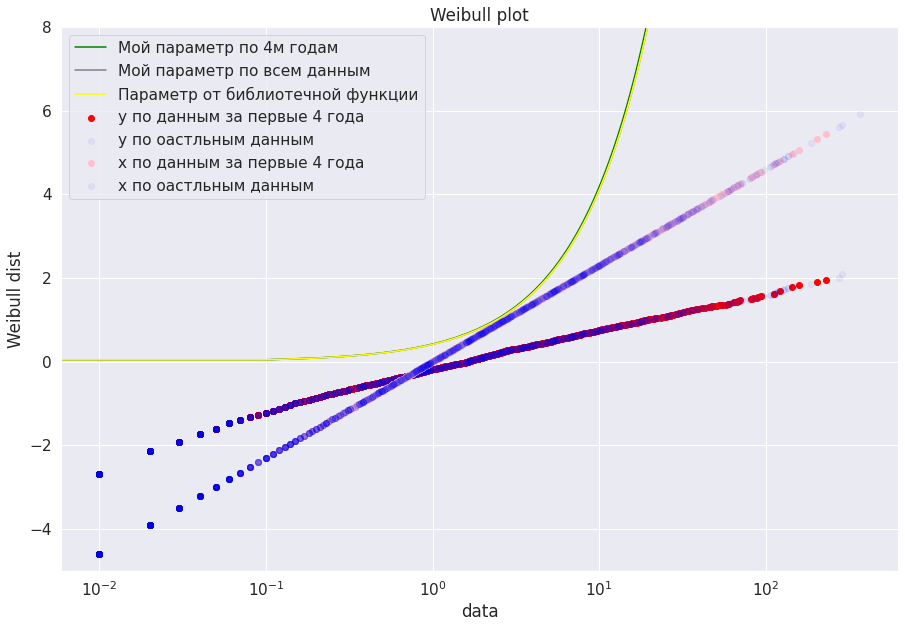

In [10]:
plt.figure(figsize=(15, 10))
plt.title('Weibull plot')
plt.xscale('log')
# Предыдущий график

# Значения y
plt.scatter(real_sample_2[:1262], np.log(-np.log(1 - ecdf_for_weibull(real_sample_2[:1262]))), 
                                                color = 'red',  label = 'y по данным за первые 4 года')
plt.scatter(real_sample_2[1262:], np.log(-np.log(1 - ecdf_for_weibull(real_sample_2[1262:]))), 
                                                color = 'blue', alpha=0.05, label = 'y по оастльным данным')

# Делаю цвет данных за первые 4 года розовым, чтоб было видно различие на графике
# Значения x
plt.scatter(real_sample_2[:1262], np.log(real_sample_2[:1262]), 
                                                color = 'pink', label = 'х по данным за первые 4 года')
plt.scatter(real_sample_2[1262:], np.log(real_sample_2[1262:]), 
                                                color = 'blue', alpha=0.05, label = 'х по оастльным данным')


# Новый график
plt.plot(np.linspace(0, 100, 1000), 0.418*np.linspace(0, 100, 1000), 
                                                         color = 'green', label = 'Мой параметр по 4м годам')
plt.plot(np.linspace(0, 100, 1000), 0.41*np.linspace(0, 100, 1000), 
                                                         color = 'grey', label = 'Мой параметр по всем данным')
plt.plot(np.linspace(0, 100, 1000), sps.weibull_min.fit(real_sample_2, fscale=1, 
              floc = 0)[0]*np.linspace(0, 100, 1000), color = 'yellow', label = 'Параметр от библиотечной функции')


plt.xlabel("data")
plt.ylim(-5, 8)
plt.legend()
plt.ylabel("Weibull dist")
plt.show()

**Вывод**: линии плохо соотвествуют выборке так как по логике они должны были пройти через точку пересечения графиков $y\prime$ и $x\prime$. 

## Задача 3

Сгенерируйте выборки $X_1, \ldots, X_N$ из $\mathit{N}(0, \theta)$, $U(0, \theta)$, $\Gamma(1, \theta)$ (**параметризация $k, \theta$**), $\theta = 3$ для всех распределений $(N = 1000).$ Для всех $n \leq N$ посчитайте значения оценок (по выборке $X_1, \ldots X_n$) методом моментов. Постройте график ошибки оценки от реального значения ($|\hat\theta - \theta|_{l_1}$) относительно размера выборки.

Зафиксирую seed для воспроизводимости и некоторые константы

In [11]:
np.random.seed(42)
N = 1000
THETA = 3

Делаем выборки


In [12]:
# Для нормального распределения берем корень от параметра, так как у него вторым параметром должен идти квадрат 
norm_vals = sps.norm.rvs(scale = THETA ** 0.5, size = N)
uniform_vals = sps.uniform.rvs(scale = THETA, size = N )
gamma_vals = sps.gamma.rvs(a=1, scale = THETA, size = N)

Чтобы посчитать оценку параметров методом моментов необходимо решить систему уравнений вида $\mathbb{E}_{\theta} g_{i}(X) = \overline{g_{i}(X)}$

Обычно $g_{i}(x) = x^i$. Возьмем такие функции и посчитаем $\mathbb{E}_{\theta} X$ и $\mathbb{E}_{\theta} X^2$ для каждого распределения

Для $\mathit{N}(0, \theta)$ будут такие значения $\mathbb{E}_{\theta} X = 0$ и $\mathbb{E}_{\theta} X^2 = \theta$

Для $U(0, \theta)$ будут такие значения $\mathbb{E}_{\theta} X = \frac{\theta}{2}$ и $\mathbb{E}_{\theta} X^2 = \frac{\theta + \theta^2}{3}$

Для $\Gamma(1, \theta)$ будут такие значения $\mathbb{E}_{\theta} X = \theta$ и $\mathbb{E}_{\theta} X^2 = \theta^2 + \theta$

Как можно заметить, чтобы оценить параметр нам достаточно посчитать $\overline{X^2}$ для нормальго распределения. Для равномерного распределения необходимо посчитать 2$\overline{X}$, а для гамма распределения $\overline{X}$

In [13]:
norm_est = np.cumsum(norm_vals ** 2) / np.arange(1, N + 1)
uniform_est = 2 * np.cumsum(uniform_vals) / np.arange(1, N + 1)
gamma_est = np.cumsum(gamma_vals) / np.arange(1, N + 1)

Теперь построим график разности полученных оценок параметра и самого параметра

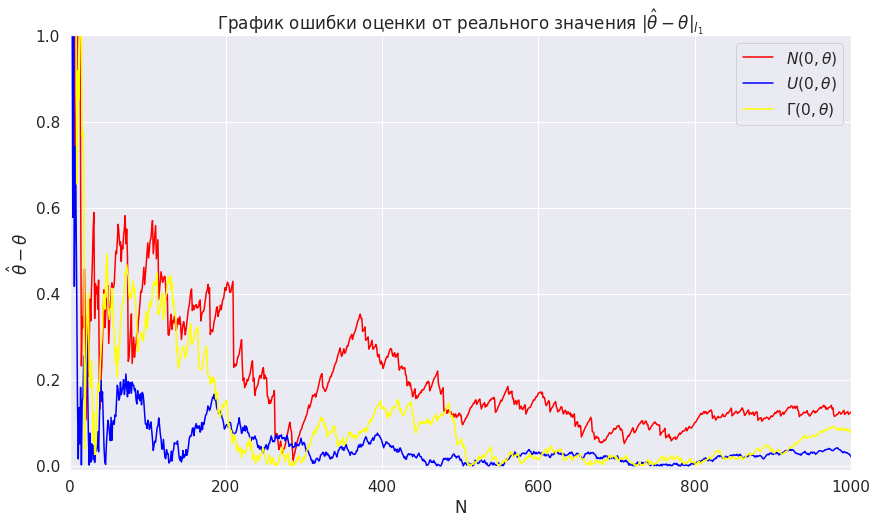

In [14]:
plt.figure(figsize=(14,8))
plt.plot(np.arange(1, N + 1), np.absolute(norm_est - THETA), color = 'red', label = "$\\mathit{N}(0, \\theta)$")
plt.plot(np.arange(1, N + 1), np.absolute(uniform_est - THETA), color = 'blue', label = "$U(0, \\theta)$")
plt.plot(np.arange(1, N + 1), np.absolute(gamma_est - THETA), color = 'yellow', label = "$\\Gamma(0, \\theta)$")
plt.title("График ошибки оценки от реального значения $|\\hat{\\theta} - \\theta|_{l_{1}}$")
plt.xlabel("N")
plt.ylabel("$\\hat{\\theta} - \\theta$")
plt.xlim(0, N) 
plt.ylim(-0.01, 1)
plt.legend()
plt.show()

**Вывод** чем больше значений тем точнее более точную оценку мы даем

### Бутстреп

Для реальных данных часто сложно подобрать распределение и нужную параметризацию относительно $\theta$. Кроме того на практике сложно посчитать дисперсию оценки (для этого хотя бы нужно знать распределение, из которого пришла выборка). На помощь в таких случаях приходит **бутстреп**.

Идея очень простая. Давайте возьмем нашу выборку размера $N$ и сгенерируем из нее еще $K$ выборок. Более формально для каждой бутстрепной выборки N раз будем выбирать элементы из исходной выборки с возвращением. Полученная таким образом выборка будет содержать $\approx 63$% уникальных элементов, но это не страшно. Для всех $K$ выборок посчитаем оценку $\hat\theta$. Таким образом мы получим $K$ оценок параметра. Можно показать, что если размер бутстрепных выборок и исходной совпадают, то оценка дисперсии $s^2(\hat\theta)$, полученная из $K$ оценок, будет *хорошей*.

Для каждого распределения из предыдущего пункта (Пожалуйста, не пишите цикл по распределениям. Сделайте три отдельные ячейки) для каждого $K$ из `[10] + [50] + list(range(100, 1001, 100))` сгенерируйте K бутстрепных выборок и посчитайте дисперсию бутстрепных оценок и посчитайте среднее по K выборкам. Размер бутстрепной выборки сделайте равным $K$, незабудьте уменьшить размер исходной выборки до $K$. Постройте график следующим образом: по оси $x$ отложите значения $K$, красной линией обозначьте среднее значение $\hat\theta$ бутстрепных выборок для каждого $K$. Посчитайте стандартное отклонение оценки для каждого $K$ и закрасьте интервал $\mu(k) \pm \sigma(\hat\theta)$ (`plt.fillbetween`).



In [16]:
# Зафиксируем параметр К
K = np.array([10, 50] + list(range(100, 1001, 100)))

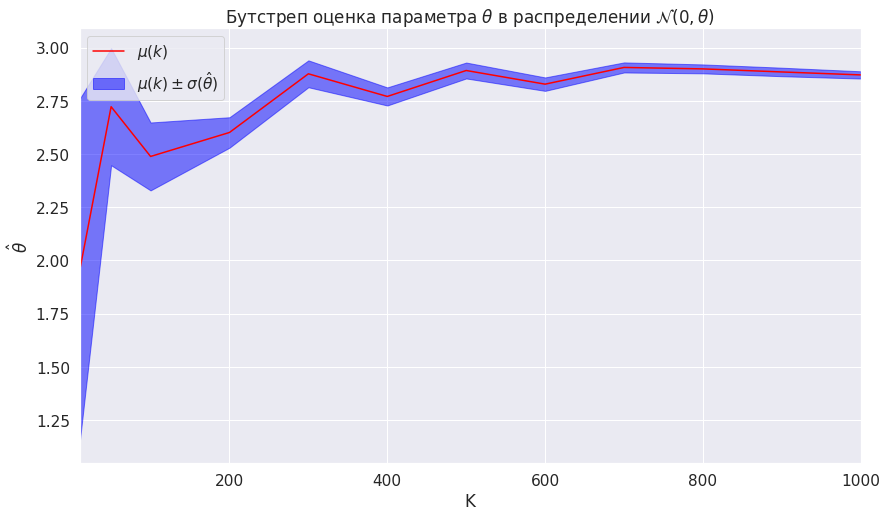

In [17]:
# Заведем массивы куда будем сохранять значения дисперсии оценок и среднего
dispersion_est = []
mean_est = []


for k in K:
    # Делаем бутстреп массивы  
    samples = [np.random.choice(norm_vals[:k], size = k) for i in range(k)]
    # Считаем оценку параметра по этим массивам. Считаем методом моментов из предыдущей клетки
    estimates = np.array([np.mean(sample ** 2) for sample in samples])
    
    # Для каждого k посчитаем среднее и дисперсию оценки
    dispersion_est.append(np.mean(estimates ** 2) - np.mean(estimates) ** 2)
    mean_est.append(np.mean(estimates))


# Сделаем из массивом массивы numpe чтобы сработал fill_between
dispersion_est = np.array(dispersion_est)
mean_est = np.array(mean_est)

# Теперь делаем график
plt.figure(figsize=(14, 8))
plt.plot(K, mean_est, color="red", label="$\\mu(k)$")
plt.fill_between(K, mean_est - dispersion_est, mean_est + dispersion_est, 
                                         label="$\\mu(k) \\pm \\sigma(\\hat{\\theta})$", alpha=0.5, color="blue")
plt.xlim(np.min(K), np.max(K))
plt.title("Бутстреп оценка параметра $\\theta$ в распределении $\\mathcal{N}(0, \\theta)$")
plt.xlabel("K")
plt.ylabel("$\\hat{\\theta}$")
plt.legend()
plt.show()

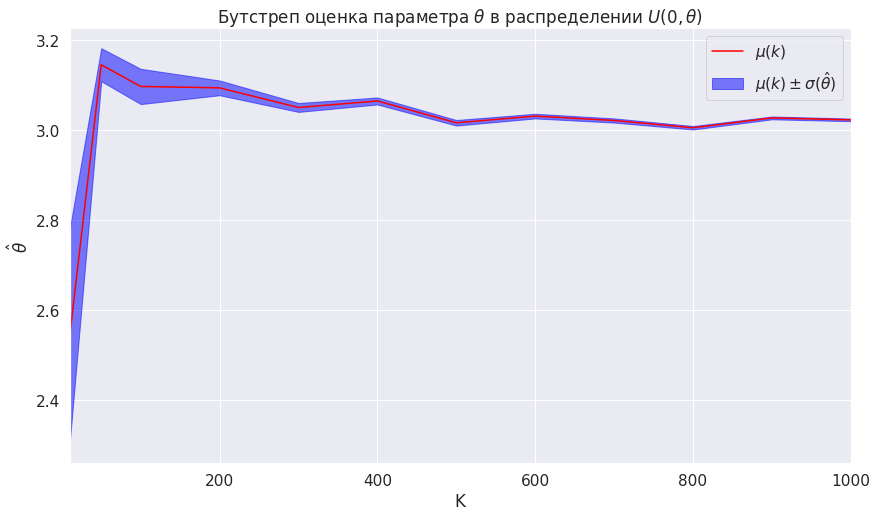

In [18]:
# Заведем массивы куда будем сохранять значения дисперсии оценок и среднего
dispersion_est = []
mean_est = []


for k in K:
    # Делаем бутстреп массивы  
    samples = [np.random.choice(uniform_vals[:k], size = k) for i in range(k)]
    # Считаем оценку параметра по этим массивам. Считаем методом моментов из предыдущей клетки
    estimates = np.array([np.mean(sample * 2) for sample in samples])
    
    # Для каждого k посчитаем среднее и дисперсию оценки
    dispersion_est.append(np.mean(estimates ** 2) - np.mean(estimates) ** 2)
    mean_est.append(np.mean(estimates))


# Сделаем из массивом массивы numpe чтобы сработал fill_between
dispersion_est = np.array(dispersion_est)
mean_est = np.array(mean_est)

# Теперь делаем график
plt.figure(figsize=(14, 8))
plt.plot(K, mean_est, color="red", label="$\\mu(k)$")
plt.fill_between(K, mean_est - dispersion_est, mean_est + dispersion_est, 
                                         label="$\\mu(k) \\pm \\sigma(\\hat{\\theta})$", alpha=0.5, color="blue")
plt.xlim(np.min(K), np.max(K))
plt.title("Бутстреп оценка параметра $\\theta$ в распределении $U(0, \\theta)$")
plt.xlabel("K")
plt.ylabel("$\\hat{\\theta}$")
plt.legend()
plt.show()

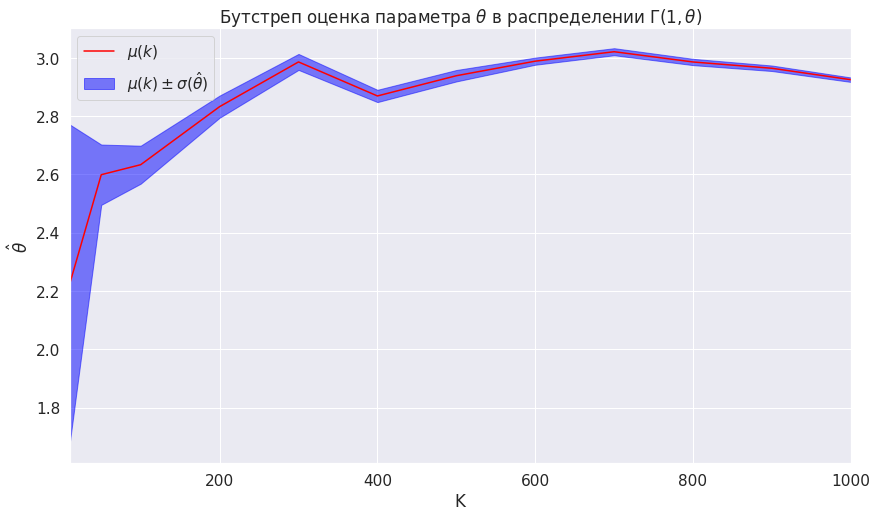

In [19]:
# Заведем массивы куда будем сохранять значения дисперсии оценок и среднего
dispersion_est = []
mean_est = []


for k in K:
    # Делаем бутстреп массивы  
    samples = [np.random.choice(gamma_vals[:k], size = k) for i in range(k)]
    # Считаем оценку параметра по этим массивам. Считаем методом моментов из предыдущей клетки
    estimates = np.array([np.mean(sample) for sample in samples])
    
    # Для каждого k посчитаем среднее и дисперсию оценки
    dispersion_est.append(np.mean(estimates ** 2) - np.mean(estimates) ** 2)
    mean_est.append(np.mean(estimates))


# Сделаем из массивом массивы numpe чтобы сработал fill_between
dispersion_est = np.array(dispersion_est)
mean_est = np.array(mean_est)

# Теперь делаем график
plt.figure(figsize=(14, 8))
plt.plot(K, mean_est, color="red", label="$\\mu(k)$")
plt.fill_between(K, mean_est - dispersion_est, mean_est + dispersion_est, 
                                     label="$\\mu(k) \\pm \\sigma(\\hat{\\theta})$", alpha=0.5, color="blue")
plt.xlim(np.min(K), np.max(K))
plt.title("Бутстреп оценка параметра $\\theta$ в распределении $\\Gamma(1, \\theta)$")
plt.xlabel("K")
plt.ylabel("$\\hat{\\theta}$")
plt.legend()
plt.show()